In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from collections import defaultdict
import re
import us

csv_path ="public_emdat_Global_techNnatural.csv"
data = pd.read_csv(csv_path)

In [54]:
#Set Color Palette for Plots and Figures
berkeley_palette_primary = ["#002676", "#FDB515"]# Skipping white "#FFFFFF"
berkeley_palette_preferred_dark = ["#010133","#FC9313", "#00553A","#770747","#431170"]

berkeley_palette_alternative_medium=["#004AAE","#FFC31B","#018943","#E7115E","#8236C7"]
berkeley_palette_alternative_light = ["#9FD1FF","#FFE88D","#B3E59A","#FFCFE5","#FFCFE5"]
berkeley_palette_black_grey=["#808080","#808080"]#Skipping black "#000000"

berkeley_palette_special_colors = ["#C09748"]
berkeley_palette_all = berkeley_palette_primary+berkeley_palette_preferred_dark+berkeley_palette_alternative_medium+berkeley_palette_alternative_light+berkeley_palette_special_colors+berkeley_palette_black_grey
text_props = {'color':"w"}

In [55]:
#Data Cleansing
drop_columns = ['Historic']

df = pd.read_csv(csv_path)
if drop_columns:
    df.drop(columns=drop_columns, inplace=True)
cleaned_data = df

Next, we are cleaning and modifying the data specific to USA to ensure all states are properly accounted for and subregions of a state are counted as an entire state

In [56]:
# Use Location column to understand which states are affected by each disaster and clean the column accordingly
# Correction key for data
us_state_names = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho",
    "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana",
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada",
    "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina",
    "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
    "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
    "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]
us_states_abbr = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", 
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", 
    "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", 
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", 
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", 
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", 
    "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", 
    "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", 
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", 
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", 
    "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", 
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", 
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", 
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", 
    "Wisconsin": "WI", "Wyoming": "WY"
}
us_state_correction = {
    "au large de la californie": "California",
    "Pacifique":"California",
    "au large de la Californie":"California",
    "nouveau mexique": "New Mexico",
    "chicago": "Illinois",
    "los angeles": "California",
    "swisher districts": "Texas",
    "rhode isl. ": "Rhode Island",
    "near los angeles": "California",
    "atlantic terminal station": "New York",
    "north california": "California",
    "los angeles": "California",
    "jerauld": "South Dakota",
    "jefferson davis": "Mississippi",
    "nassau-florida": "Florida",
    "wilkes": "North Carolina",
    "noble in richland": "Illinois",
    "marion-in": "Indiana",
    "central michigan ": "Michigan",
    "south california": "California",
    "south-western louisiana": "Louisiana",
    "north california ": "California",
    "northern washington ": "Washington",
    "central-northern usa": "None",
    "montana and idaho s": "None",
    "hollywood": "California",
    "eastern washington ": "Washington",
    "eastern new mexico": "New Mexico",
    "district of columbia":"Washington, D.C.",
    "Nouveau Mexique" :"New Mexico"
}

# Supporting Function to Clean Location column 
def extract_state(x):
    if "(" in x:
        #x = x.replace(";",",")
        return re.findall(r'\((.*?)\)', x)
    if "," in x:
        #print("data with ,",x.split(","))
        return x.split(",")
    return [x]

# This line is if the location contains valid state. no need to continue further.
def segregate_state(x):
    x = re.sub(r'\s+s$', '', x) # Remove location with ' s' added to the valid state
    x = x.strip() # Remove extra spaces 
    x = re.sub(r'\s+and\s+', ',', x) # replace states that has 'and' with ','
    x = re.sub(r' near ', '', x) # remove state with near keyword
    x = re.sub(r'^.*?,\s*', '', x) # Regex to remove everything to the left of the comma
    
    if x in us_state_correction.keys():
        x = us_state_correction[x] # Check if the state is valid
    x_state = us.states.lookup(x).__str__()
    if not x_state == 'None':
        return x_state.capitalize().strip()
    else:
        # Find words that contain the substring
        x_state = [st for st in us_states_abbr.keys() if  st.lower() in x]
        if len(x_state) > 0:
            return x_state
        else:
            return x # if not valid return as-is

data_usa = data[data.Country == 'United States of America'].reset_index(drop=True)
locations=list(data_usa['Location'])

# Fix the following :
# We have some states in brackets '()'
# the state name is attached with text 'province' 
# The state name is attached with text 'state'
# Some location column has more than one state combined in one row. We will duplicate those rows and add rows for each state in seperate rows
# We will also fix letter cases.The capitalize() method returns a string where the first character is upper case, and the rest is lower case.

data_usa['Location'] = data_usa['Location'].fillna("")
pattern = '|'.join(['province', 'provinces','state','State','nan'])
# Extract text inside parent heses and split by ';'
data_usa['Location'] = data_usa['Location'].str.replace(pattern, '', regex=True)
data_usa['Location'] = data_usa['Location'].str.replace(',\s+', ',', regex=True)
data_usa['Extracted State'] = data_usa['Location'].apply(extract_state)
data_usa_exploded = data_usa.explode('Extracted State').reset_index(drop=True)
data_usa_exploded['Extracted State'] = data_usa_exploded['Extracted State'].apply(segregate_state)

# Cleaning the rows with Location as Nan 
# REferences :https://stackoverflow.com/questions/73285289/remove-rows-in-dataframe-only-if-a-certain-condition-is-met-using-pandas
data_usa_exploded['Extracted State'].dropna(axis=0,inplace=True) # aqbove one is more efficient 
data_usa_exploded.reset_index(drop=True)
data_usa_exploded["Extracted State"] = data_usa_exploded["Extracted State"].str.capitalize()
data_usa_natural_explode = data_usa_exploded[data_usa_exploded['Disaster Group'] == 'Natural']
data_usa_natural_explode['Extracted State']

# Remove the Location not in Valid US State 
data_usa_natural_explode.reset_index(drop=True,inplace=True)
data_usa_natural_explode_us_state = data_usa_natural_explode[data_usa_natural_explode['Extracted State'].isin(us_state_names)]
data_usa = data_usa_natural_explode_us_state
data_usa.shape

(2413, 47)

What types of disasters have been recorded worldwide to date?

In [57]:
diaster_start_year = cleaned_data['End Year'].min() # 2001
diaster_end_year = cleaned_data['End Year'].max() # 2024 
print(f"Disaster Types recorded worldwide & its count recorded from {diaster_start_year} to {diaster_end_year} :")
print(f"{'-'*65}")
hierachial_disaster_group = cleaned_data.groupby(['Disaster Group','Disaster Subgroup','Disaster Type']).size().reset_index(name='count')
pd.DataFrame(hierachial_disaster_group.sort_values(by=['Disaster Group', 'Disaster Subgroup', 'count'], ascending=[True, True, False]))

Disaster Types recorded worldwide & its count recorded from 2000 to 2024 :
-----------------------------------------------------------------


,Disaster Group,Disaster Subgroup,Disaster Type,count
1,Natural,Biological,Epidemic,868
2,Natural,Biological,Infestation,29
0,Natural,Biological,Animal incident,1
3,Natural,Climatological,Drought,415
5,Natural,Climatological,Wildfire,316
4,Natural,Climatological,Glacial lake outburst flood,5
6,Natural,Extra-terrestrial,Impact,1
7,Natural,Geophysical,Earthquake,670
9,Natural,Geophysical,Volcanic activity,128
8,Natural,Geophysical,Mass movement (dry),13


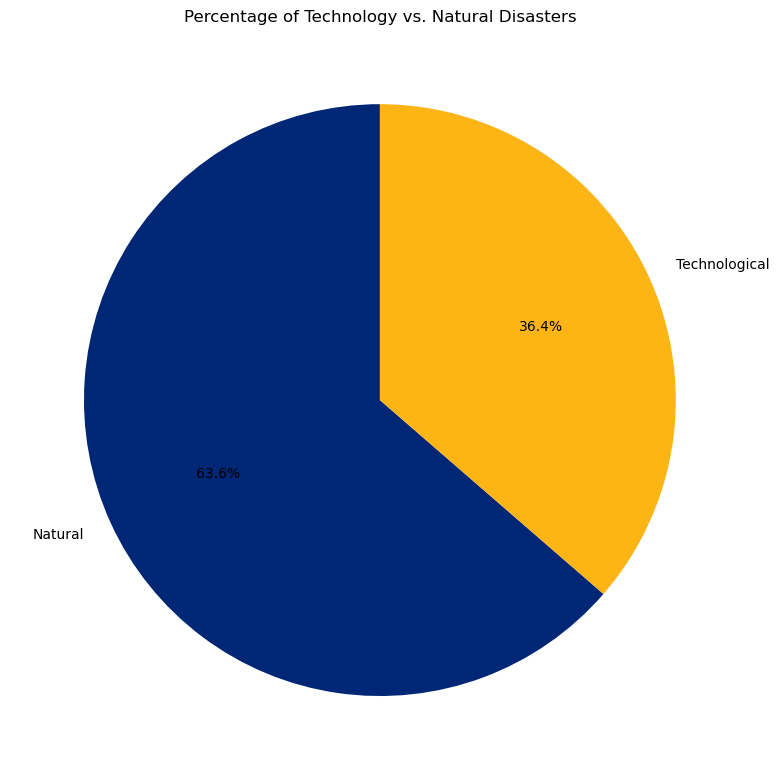

In [58]:
disaster_group_data = hierachial_disaster_group.groupby("Disaster Group")["count"].sum().reset_index()
disaster_subgroup_data = hierachial_disaster_group.groupby(["Disaster Group", "Disaster Subgroup"])["count"].sum().reset_index()

# Pie Chart 1: Technology vs. Natural Disasters
plt.figure(figsize=(8, 8))
plt.pie(
    disaster_group_data["count"],
    labels=disaster_group_data["Disaster Group"],
    autopct='%1.1f%%',
    startangle=90,
    colors=berkeley_palette_primary
)
plt.title("Percentage of Technology vs. Natural Disasters")
plt.tight_layout()
plt.show()

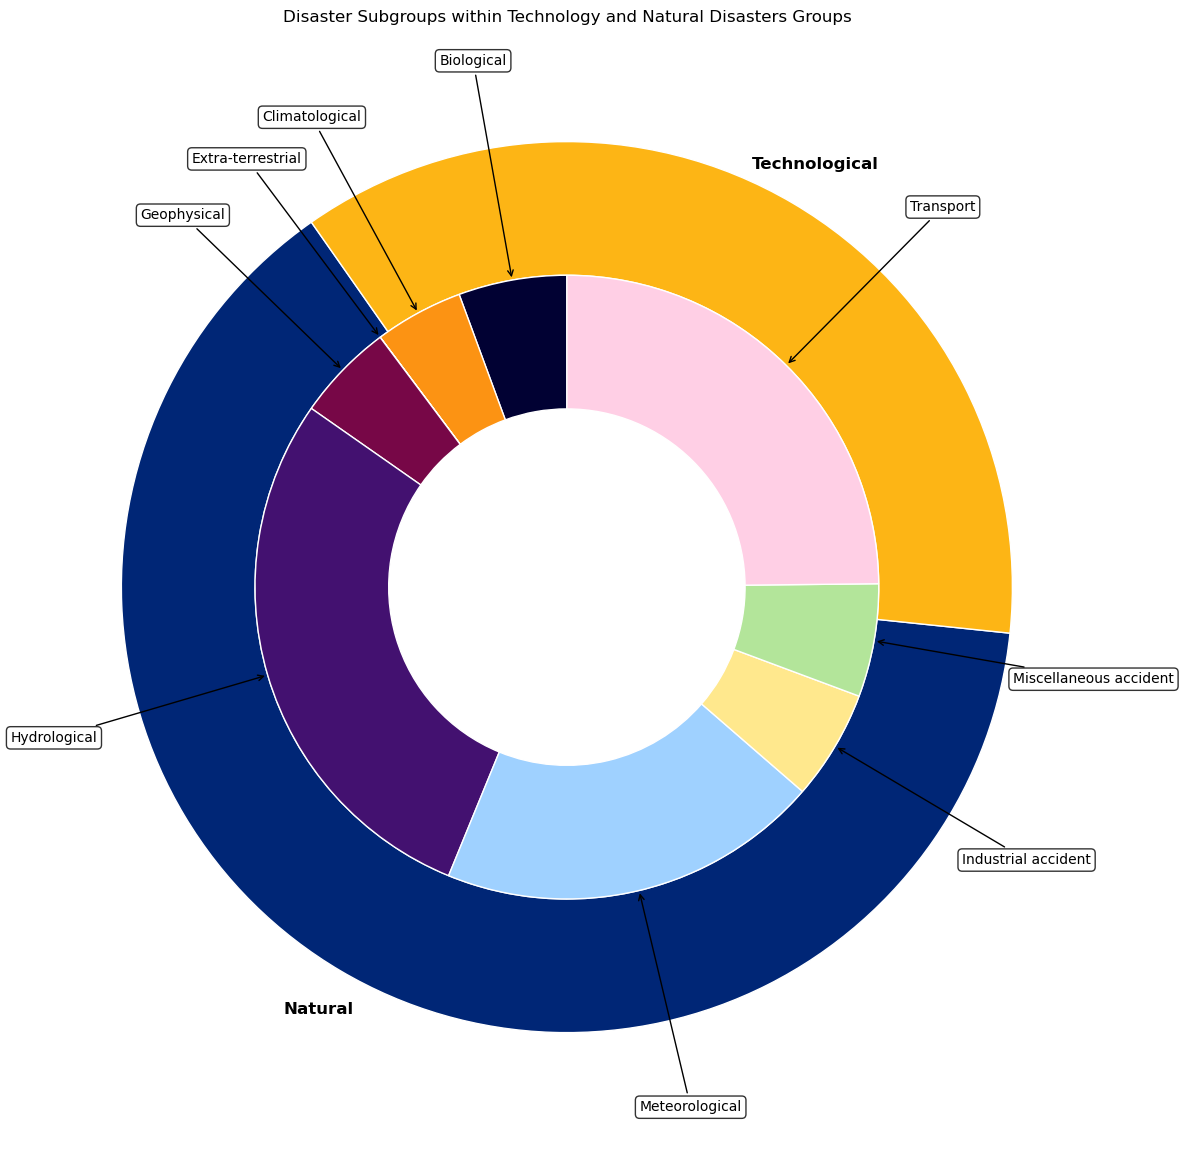

In [59]:
outer_pie_data = (
    cleaned_data.groupby("Disaster Group")
    .size()
    .reset_index(name = "count")
)
inner_pie_data = (
    cleaned_data.groupby(["Disaster Group", "Disaster Subgroup"])
    .size()
    .reset_index(name = "count")
)

fig, ax = plt.subplots(figsize=(12, 12))

#Outer Group
outer_pie, _ = ax.pie(
    outer_pie_data["count"],
    labels = None,
    radius = 1,
    colors = berkeley_palette_primary,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    startangle= 125
)

for i, p in enumerate(outer_pie):
    theta = (p.theta2 - p.theta1)/2 + p.theta1

    x = 1.1 * np.cos(np.radians(theta))
    y = 1.1 * np.sin(np.radians(theta))

    ax.text(
        x, y,
        outer_pie_data["Disaster Group"].iloc[i],
        fontsize = 12, ha = "center", va = "center", fontweight="bold", color="black"
    )


inner_pie, _ = ax.pie(
    inner_pie_data["count"],
    radius = 1-0.3,
    colors = (berkeley_palette_preferred_dark + berkeley_palette_alternative_light + berkeley_palette_alternative_medium)[:len(disaster_subgroup_data)],
    labels= None,
    wedgeprops = dict(width = 0.3, edgecolor='w'),
    startangle = 90
)

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
arrow_props = dict(arrowstyle="->", color="black", lw=1)

for i, (p, label) in enumerate(zip(inner_pie, inner_pie_data["Disaster Subgroup"])):
    theta = (p.theta2 - p.theta1)/2 + p.theta1

    x = (1 - 0.3) * np.cos(np.radians(theta))
    x_label = 1.2 * np.cos(np.radians(theta))
    y = (1 - 0.3) * np.sin(np.radians(theta))
    y_label = 1.2 * np.sin(np.radians(theta))

    ax.annotate(
        label,
        xy = (x, y),
        xytext = (x_label, y_label),
        arrowprops = arrow_props,
        bbox = bbox_props,
        fontsize = 10, ha = "center", va = "center"
    )

ax.set(aspect="equal", title = "Disaster Subgroups within Technology and Natural Disasters Groups")
plt.tight_layout()
plt.show()

What are the top 10 countries with the most disasters?

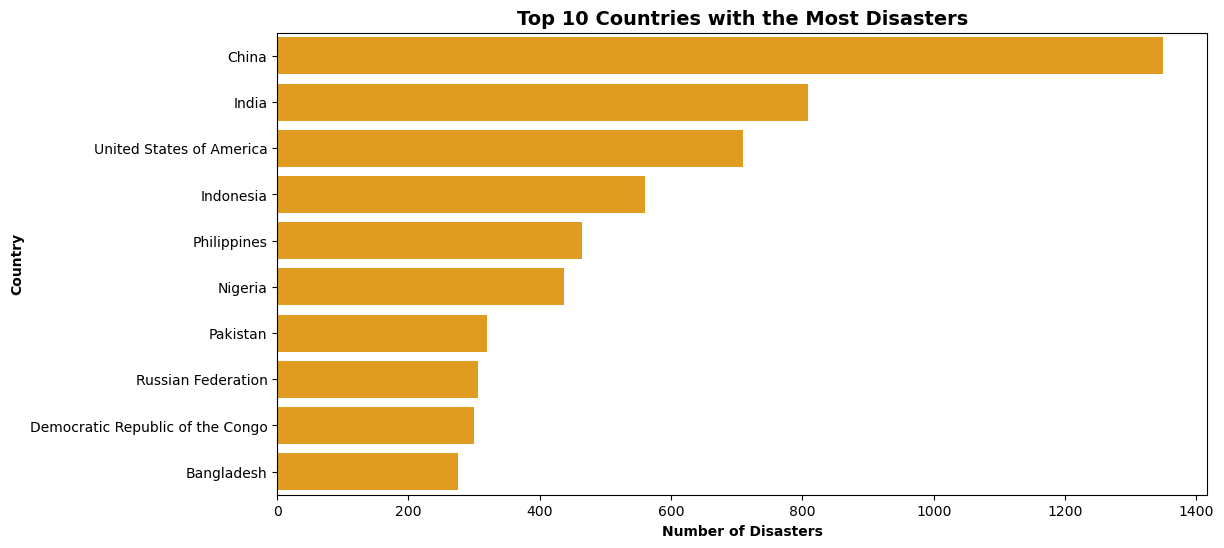

In [69]:
# Aggregate disaster counts by country
top_countries = data['Country'].value_counts().head(10).reset_index()
top_countries.columns = ['Country', 'Disaster Count']

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_countries, x='Disaster Count', y='Country', color="Orange")
plt.title('Top 10 Countries with the Most Disasters', fontsize=14,weight='bold')
plt.xlabel('Number of Disasters',fontdict={'weight': 'bold'})
plt.ylabel('Country',fontdict={'weight': 'bold'})
plt.show()

Which countries are most affected by Natural Disasters?

/var/folders/gj/bbgjz4_x5ybc58ms5zv9p8sr0000gp/T/ipykernel_26824/1382384718.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20') # Colour map (there are many others)


<Figure size 1200x800 with 0 Axes>

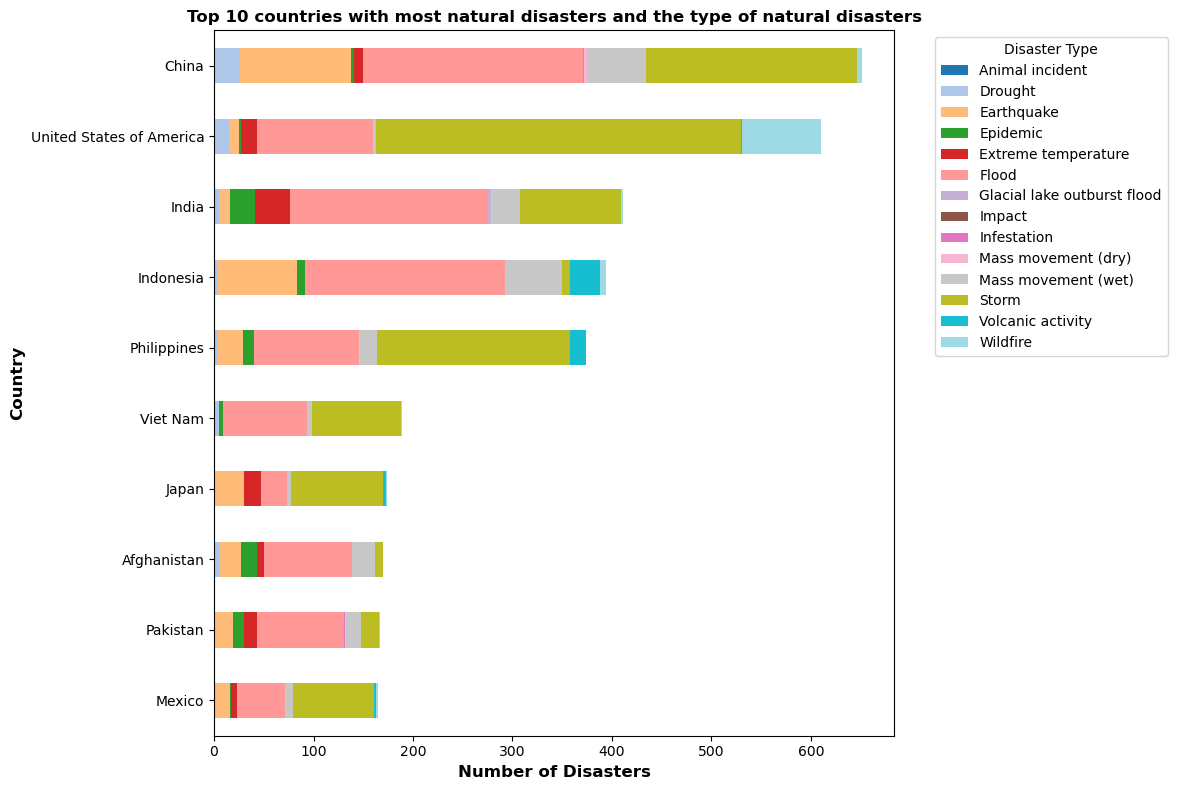

Disaster Type,Animal incident,Drought,Earthquake,Epidemic,Extreme temperature,Flood,Glacial lake outburst flood,Impact,Infestation,Mass movement (dry),Mass movement (wet),Storm,Volcanic activity,Wildfire
Country,,,,,,,,,,,,,,
Mexico,0,2,14,1,6,48,0,0,0,0,8,82,2,2
Pakistan,0,1,18,11,13,88,0,0,1,1,15,18,0,1
Afghanistan,0,6,21,16,7,89,0,0,0,0,23,8,0,0
Japan,0,0,30,0,17,26,0,0,0,0,4,93,3,1
Viet Nam,0,5,0,4,0,84,0,0,0,0,5,90,0,1
Philippines,0,4,25,11,0,106,0,0,0,1,17,194,16,0
Indonesia,0,3,80,8,0,201,0,0,0,0,58,8,30,6
India,0,5,11,25,35,199,3,0,0,1,29,101,0,2
United States of America,0,15,10,2,16,117,0,0,0,0,3,367,1,79


In [ ]:
data_natural = data[data["Disaster Group"] == "Natural"]
natural_count = data_natural["Country"].value_counts().head(10)
natural_type = data_natural.groupby(["Country", "Disaster Type"]).size().unstack(fill_value=0)

top_10_countries = natural_count.index
disaster_type_top_10 = natural_type.loc[top_10_countries]
disaster_type_top_10_sorted = disaster_type_top_10.loc[disaster_type_top_10.sum(axis=1).sort_values(ascending=True).index]

plt.figure(figsize=(12, 8))
cmap = cm.get_cmap('tab20') # Colour map (there are many others)

disaster_type_top_10_sorted.plot(kind="barh", stacked=True, figsize=(12,8),colormap=cmap)

plt.title("Top 10 countries with most natural disasters and the type of natural disasters",weight='bold')
plt.xlabel("Number of Disasters", fontsize=12,fontdict={'weight': 'bold'})
plt.ylabel("Country", fontsize=12,fontdict={'weight': 'bold'})
plt.legend(title="Disaster Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
disaster_type_top_10_sorted

In [97]:
import matplotlib.pyplot as plt
import numpy as np

numbers = np.linspace(0,1,6)
newcm = plt.cm.Accent(numbers)
print(newcm)

[[0.49803922 0.78823529 0.49803922 1.        ]
 [0.74509804 0.68235294 0.83137255 1.        ]
 [1.         1.         0.6        1.        ]
 [0.21960784 0.42352941 0.69019608 1.        ]
 [0.74901961 0.35686275 0.09019608 1.        ]
 [0.4        0.4        0.4        1.        ]]


What are the Top 20 US states affected by disasters?

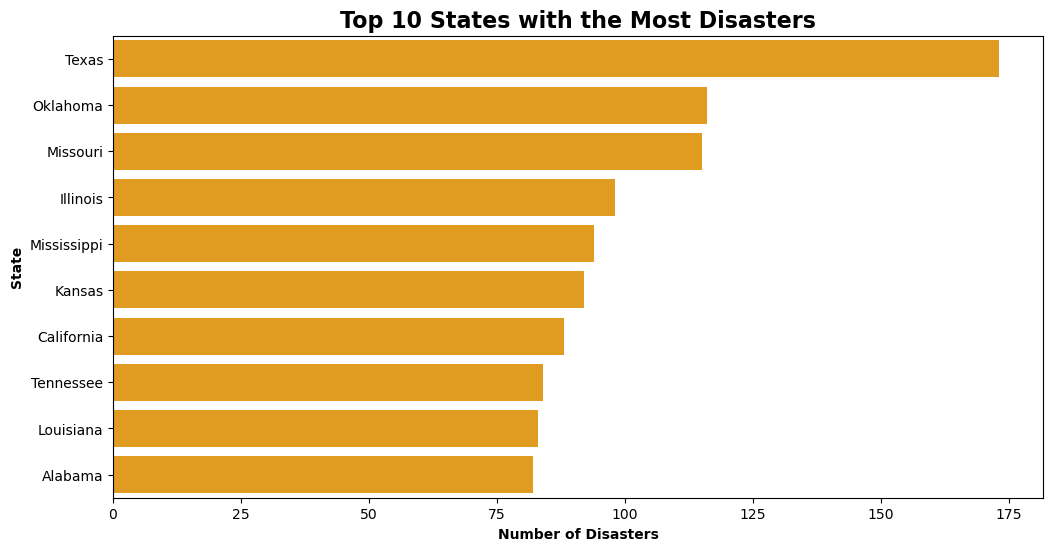

In [71]:
# Aggregate disaster counts by State
top_states = data_usa['Extracted State'].value_counts().head(10).reset_index()
top_states.columns = ['Extracted State', 'Disaster Count']

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_states, x='Disaster Count', y='Extracted State', color="orange")
plt.title('Top 10 States with the Most Disasters', fontsize=16,weight='bold')
plt.xlabel('Number of Disasters',fontdict={'weight': 'bold'})
plt.ylabel('State',fontdict={'weight': 'bold'})
plt.show()

What are the top 20 US States that are most affected by natural disasters?

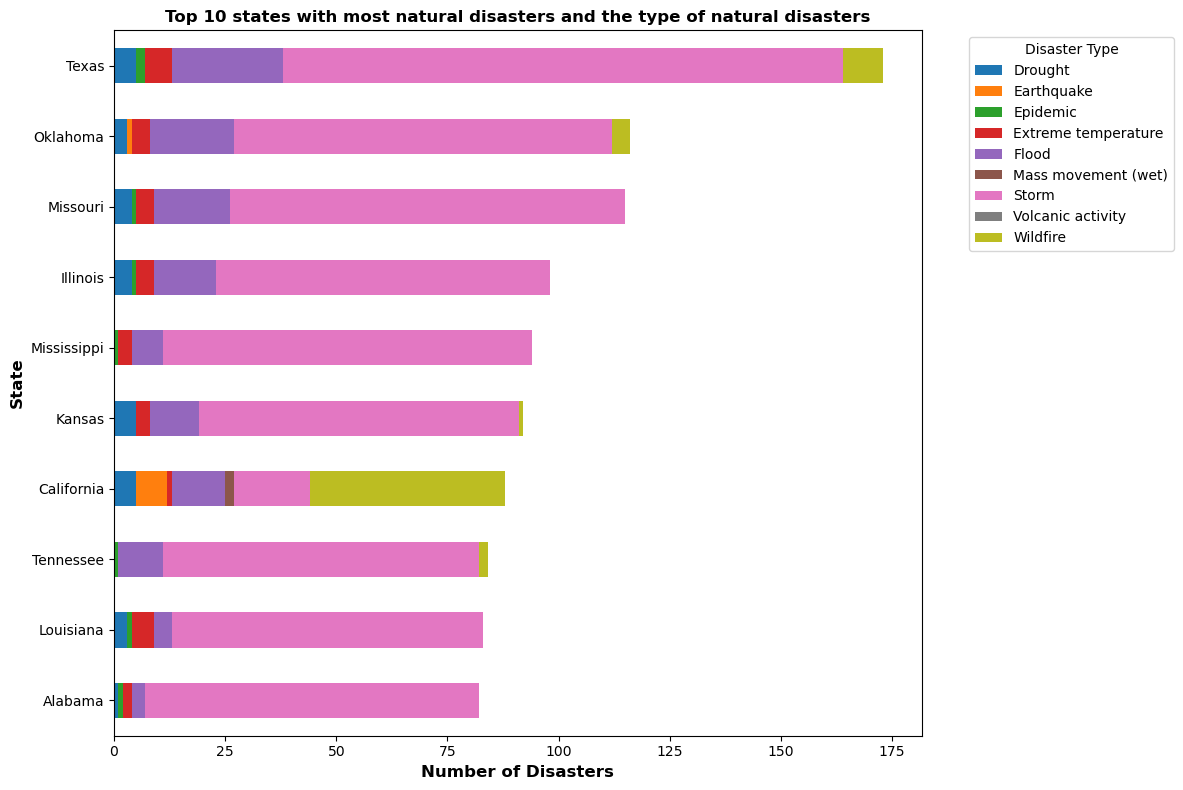

In [106]:
data_usa_natural = data_usa[data_usa["Disaster Group"] == "Natural"]
natural_usa_count = data_usa_natural["Extracted State"].value_counts().head(10)
natural_usa_type = data_usa_natural.groupby(["Extracted State", "Disaster Type"]).size().unstack(fill_value=0)

top_10_states = natural_usa_count.index
disaster_type_usa_top_10 = natural_usa_type.loc[top_10_states]
disaster_type_usa_top_10_sorted = disaster_type_usa_top_10.loc[disaster_type_usa_top_10.sum(axis=1).sort_values(ascending=True).index]

disaster_type_usa_top_10_sorted.plot(kind="barh", stacked=True, figsize=(12,8))
plt.title("Top 10 states with most natural disasters and the type of natural disasters",weight='bold')
plt.xlabel("Number of Disasters", fontsize=12,fontdict={'weight': 'bold'})
plt.ylabel("State", fontsize=12,fontdict={'weight': 'bold'})
plt.legend(title="Disaster Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Does frequency of disaster vary depending on time of the year in the USA?

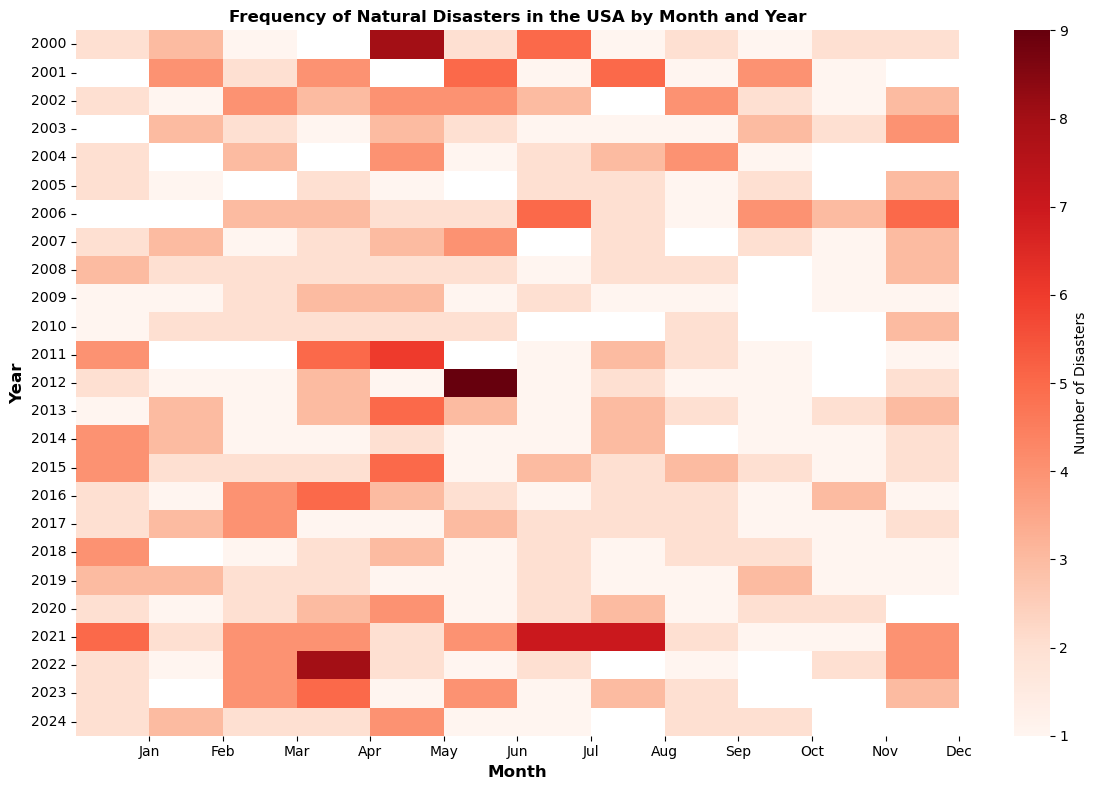

In [64]:
# Clean the data to include correct start and end date, and remove any data that doesn't have a start or end date
cleaned_date_data = data[~(data['Start Month'].isnull() | data['End Month'].isnull())].reset_index()

usa_natural_disasters_date_data = (
    cleaned_date_data[
        (cleaned_date_data["Country"] == "United States of America") &
        (cleaned_date_data["Disaster Group"] == "Natural")
    ]
)
usa_natural_disaster_frequency = (usa_natural_disasters_date_data.groupby(["Start Year", "Start Month"]).size().reset_index(name="Frequency"))
usa_natural_disasters_matrix = (usa_natural_disaster_frequency.pivot(index="Start Year", columns="Start Month", values="Frequency"))

plt.figure(figsize=(12,8))
sns.heatmap(usa_natural_disasters_matrix, cmap="Reds", annot=False, cbar_kws={"label": "Number of Disasters"})
plt.title("Frequency of Natural Disasters in the USA by Month and Year",weight='bold')
plt.xlabel("Month", fontsize=12,fontdict={'weight': 'bold'})
plt.ylabel("Year", fontsize=12,fontdict={'weight': 'bold'})
plt.xticks(ticks=range(1,13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.tight_layout()
plt.show()

What is the frequency of each disaster type across all countries?

<Figure size 1200x600 with 0 Axes>

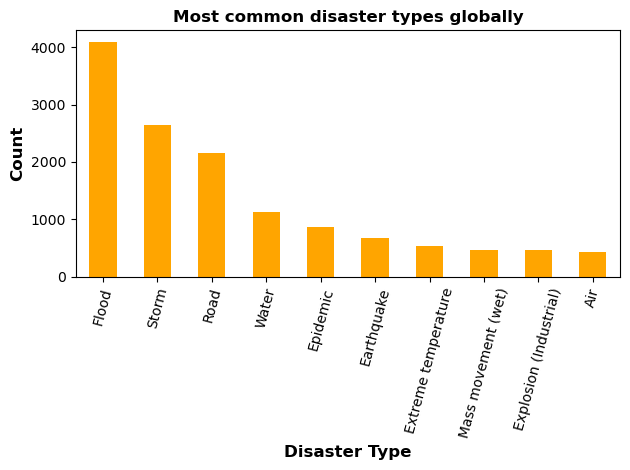

In [65]:
global_disaster_types = data["Disaster Type"].value_counts().reset_index()
global_disaster_types.columns = ["Disaster Type", "Frequency"]

plt.figure(figsize=(12, 6))
global_disaster_types.head(10).plot(kind='bar', x="Disaster Type", y="Frequency", color="orange", legend=False) ##002676
plt.title("Most common disaster types globally",weight='bold')
plt.xlabel("Disaster Type", fontsize=12,fontdict={'weight': 'bold'})
plt.ylabel("Count", fontsize=12,fontdict={'weight': 'bold'})
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()
pass

What is the frequency of each disaster type across the states?

<Figure size 1200x600 with 0 Axes>

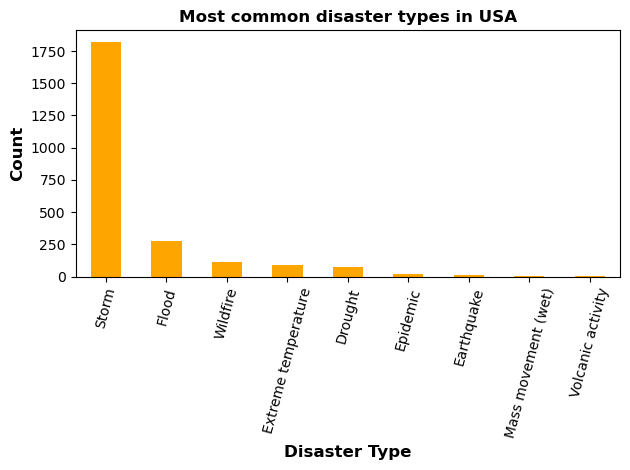

In [66]:
us_disaster_types = data_usa["Disaster Type"].value_counts().reset_index()
us_disaster_types.columns = ["Disaster Type", "Frequency"]

plt.figure(figsize=(12, 6))
us_disaster_types.head(10).plot(kind='bar', x="Disaster Type", y="Frequency", color="orange", legend=False)
plt.title("Most common disaster types in USA",weight='bold')
plt.xlabel("Disaster Type", fontsize=12,fontdict={'weight': 'bold'})
plt.ylabel("Count", fontsize=12,fontdict={'weight': 'bold'})
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


Load secondary dataset to help understand trends over a bigger timeframe in the USA

In [67]:
state_freq_data = pd.read_csv('state_freq_data.csv', skiprows=1)


Using this new dataset, plot historical trend with natural disasters from 1980-2024

In [68]:
freq_trend =  state_freq_data.groupby('year').sum().sum(axis=1)

spike_years = [2011, 2008, 2015, 2020, 2023]
spike_years_data = state_freq_data[state_freq_data['year'].isin(spike_years)]
spike_years_summary = spike_years_data.groupby('year').sum()

# Plot Temporal Trend
plt.figure(figsize=(12, 6))
plt.plot(freq_trend.index, freq_trend.values, label="Disaster Count", marker='o', color='#002676')
for year in spike_years:
    plt.axvline(x=year, color='#FDB515', linestyle='--', alpha=0.7)
plt.title("Temporal Trends in Disaster Count (1980-2024)")
plt.xlabel("Year")
plt.ylabel("Total Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: can only concatenate str (not "int") to str

Plot distribution of disasters in spike years

In [ ]:
spike_years_summary.drop(columns="year", errors="ignore")
spike_years_summary.plot(kind="bar",stacked=True, figsize=(12, 6))
plt.title("Distribution of disasters in spike years",weight='bold')
plt.xlabel("Year",fontdict={'weight': 'bold'})
plt.ylabel("Disaster Count",fontdict={'weight': 'bold'})
plt.legend(title="Disaster Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

NameError: name 'spike_years_summary' is not defined